## Import necessary libraries

In [607]:
from pathlib import Path
import numpy as np
import hist.dask as had
from matplotlib import pyplot as plt
import awkward as ak
import dask
from hist.dask import Hist
from coffea.nanoevents import NanoEventsFactory, PHYSLITESchema, BaseSchema
from coffea.analysis_tools import PackedSelection
import mplhep
import uproot
import coffea.nanoevents
from tqdm import tqdm_notebook


PHYSLITESchema.warn_missing_crossrefs = False

In [106]:
from importlib.metadata import version

for package in ["numpy", "awkward", "uproot", "coffea", "dask"]:
    print(f"# {package}: v{version(package)}")

# numpy: v1.26.4
# awkward: v2.6.5
# uproot: v5.3.9
# coffea: v2024.5.0
# dask: v2024.6.2


## Use NanoEventsFactory in coffea to import root file

In [571]:
# s3df file path
# file_path = "/fs/ddn/sdf/group/ldmx/users/dongyi/Higgs/evttree-mc23_13p6TeV.801169.Py8EG_A14NNPDF23LO_jj_JZ4.deriv.DAOD_PHYS.e8514_s4159_r14799_p5855.root"
# uchicago file path
file_path = "/data/dliu64/Higgs_analysis/evttree-mc23_13p6TeV.801169.Py8EG_A14NNPDF23LO_jj_JZ4.deriv.DAOD_PHYS.e8514_s4159_r14799_p5855.root"
file_path=f"{file_path}{':evttree'}"



In [572]:
def filter_name(name):
    return name in [
        'HLT_j420_L1J100',
        'fatJetGN2XHbb', 'fatJetGN2XHcc',  
        'fatJetGN2Xv01Hbb', 'fatJetGN2Xv01Hcc', 'fatJetGN2Xv01QCD',
        'fatJetGN2XQCD', 'fatJetPt',
        'fatJetPx', 'fatJetPy',
        'fatJetPz', 'fatJetE',
        'fatJetM', 'fatJetNCHadrons', 
        'fatJetNBHadrons', 'vrJetIdFatJet', 
        'vrJetHadronGhostTruthLabelID', 'vrJetPt', 
        'vrJetM', 'eventMCWeight'
    ]

In [580]:
events = NanoEventsFactory.from_root(
    file_path,
    schemaclass=BaseSchema,
    uproot_options=dict(filter_name=filter_name),
    delayed=True,
).events()

### General features of triggers

In [ ]:
tirgger = events.HLT_j420_L1J100.compute()
#trigger
# trigger is just a bunch of True and false boolean variable

### Peep general features of fatjets

In [583]:
fatjetpt = events.fatJetPt.compute()
double_fatjet = fatjetpt[ak.num(fatjetpt)==2]
if len(double_fatjet) == len(double_fatjet[double_fatjet[:,0]-double_fatjet[:,1]>=0]):
    print('double fatjetpt is sorted')
else:
    print('double fatjetpt is not sorted')
fatjetpt

double fatjetpt is sorted


<Array [[615, 295], [...], ..., [565, 502]] type='4078050 * [var * float32[...'>

In [8]:
N_tot = len(events.compute())
N_max_fatjet = ak.max(ak.num(fatjetpt))
print('The maximum number of fatjets is %i'%N_max_fatjet)
for i in range(N_max_fatjet):
    print('The number of events with %i fatjet(s) is %i, fraction is %.1f%%'%(i+1, len(fatjetpt[ak.num(fatjetpt)==i+1]), len(fatjetpt[ak.num(fatjetpt)==i+1])/N_tot*100))

The maximum number of fatjets is 7
The number of events with 1 fatjet(s) is 473620, fraction is 11.6%
The number of events with 2 fatjet(s) is 3190476, fraction is 78.2%
The number of events with 3 fatjet(s) is 376796, fraction is 9.2%
The number of events with 4 fatjet(s) is 24284, fraction is 0.6%
The number of events with 5 fatjet(s) is 1180, fraction is 0.0%
The number of events with 6 fatjet(s) is 43, fraction is 0.0%
The number of events with 7 fatjet(s) is 2, fraction is 0.0%


## Fatjet kinematics
Applying double fatjets cut, and looking into the mass and pT of leading and subleading fatjet distribution.

In [9]:
selection_2fatjet = ak.num(fatjetpt, axis=-1) == 2
selection_1fatjet = ak.num(fatjetpt, axis=-1) == 1
selection_multi_fatjet = ak.num(fatjetpt, axis=-1) > 2
event_1fatjet = events[selection_1fatjet].compute()
event_2fatjet = events[selection_2fatjet].compute()
event_multi_fatjet = events[selection_multi_fatjet].compute()
tot_N = len(events.compute())
single_N = len(event_1fatjet)
double_N = len(event_2fatjet)
multi_N = len(event_multi_fatjet)
print('total event number is %i,\nzero fatjet events are %i,\nsingle fatjet events are %i, %.3f%%,\ndouble fatjets events are %i, %.3f%%,\nmulti fatjets events are %i, %.3f%%'\
      %(tot_N, tot_N-(single_N+double_N+multi_N), single_N, single_N/tot_N*100, double_N, double_N/tot_N*100, multi_N, multi_N/tot_N*100))

total event number is 4078050,
zero fatjet events are 11649,
single fatjet events are 473620, 11.614%,
double fatjets events are 3190476, 78.235%,
multi fatjets events are 402305, 9.865%


The range of leading fatjet pT is from 200.7 to 1520.8 GeV
The range of subleading fatjet pT is from 200.0 to 1406.8 GeV


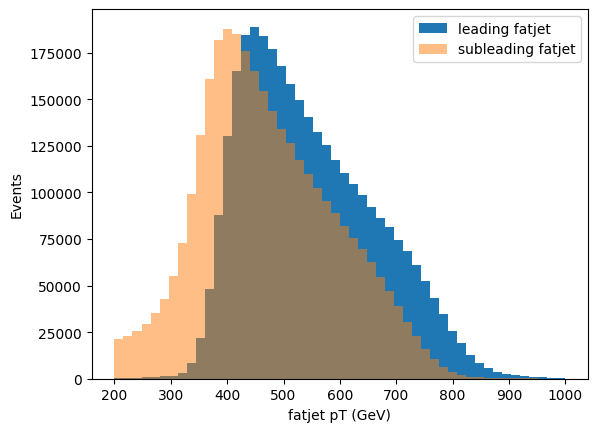

In [10]:
pT_leading_fatjet = events.fatJetPt[selection_2fatjet][:,0].compute()
pT_subleading_fatjet = events.fatJetPt[selection_2fatjet][:,1].compute()
print('The range of leading fatjet pT is from %.1f to %.1f GeV'%(ak.min(pT_leading_fatjet),ak.max(pT_leading_fatjet)))
print('The range of subleading fatjet pT is from %.1f to %.1f GeV'%(ak.min(pT_subleading_fatjet),ak.max(pT_subleading_fatjet)))

plt.hist(pT_leading_fatjet, bins=50, range=(200, 1000), label='leading fatjet')
plt.hist(pT_subleading_fatjet, bins=50, range=(200, 1000), alpha=.5, label='subleading fatjet')
plt.xlabel(r"fatjet pT (GeV)")
plt.ylabel("Events")
plt.legend()

The range of leading fatjet mass is from -0.0 to 866.3 GeV
The range of subleading fatjet mass is from -0.0 to 683.3 GeV


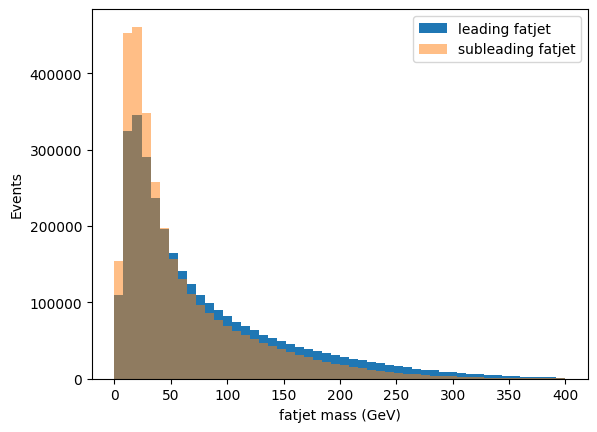

In [11]:
mass_leading_fatjet = events.fatJetM[selection_2fatjet][:,0].compute()
mass_subleading_fatjet = events.fatJetM[selection_2fatjet][:,1].compute()
print('The range of leading fatjet mass is from %.1f to %.1f GeV'%(ak.min(mass_leading_fatjet),ak.max(mass_leading_fatjet)))
print('The range of subleading fatjet mass is from %.1f to %.1f GeV'%(ak.min(mass_subleading_fatjet),ak.max(mass_subleading_fatjet)))

plt.hist(mass_leading_fatjet, bins=50, range=(0, 400), label='leading fatjet')
plt.hist(mass_subleading_fatjet, bins=50, range=(0, 400), alpha=.5, label='subleading fatjet')
plt.xlabel(r"fatjet mass (GeV)")
plt.ylabel("Events")
plt.legend()

## Use vrjets to do the flavor tagging

### Understanding the meanings of vrjets's labels

**What is vrjets?**

`vrjets` are those have small cone size inside one fatjet.

`vrJetIdFatJet` means which vrjets belong to which fatjet. Those vrjets labeled with 0 means they are in leading fatjet.

In [12]:
vrjet = events.vrJetIdFatJet.compute()
vrjet[ak.num(vrjet[vrjet==6])>0]
vrjet

<Array [[0, 0, 1, 1], ..., [0, 0, ..., 1, 1]] type='4078050 * [var * int32[...'>

In [13]:
vrjetpt = events.vrJetPt.compute()
vrjetpt[ak.num(vrjet[vrjet==6])>0]
vrjetpt

<Array [[6.65, 375, 12.1, 314], ..., [...]] type='4078050 * [var * float32[...'>

`vrJetHadronGhostTruthLabelID` is to classify quark's flavor of each vrjet, which is equivalent to flavor tagging. Note, this is truth-level information, only valid in MC simulation
- `vrJetHadronGhostTruthLabelID=0`, means light quark (u, d, s)
- `vrJetHadronGhostTruthLabelID=4`, means c quark
- `vrJetHadronGhostTruthLabelID=5`, means b quark

In [ ]:
events.vrJetHadronGhostTruthLabelID.compute()

### Selection rules
Since we only care about vrjets inside the leading fatjet, so only those vrjets label with 0 will be used.
`vrJetIdFatJet==0` & `vrJetPt>20`

In [14]:
# still contains zero fatjet events
'''Why does the following doesn't work

#selection_vrjet_id_0 = (vrjetid==0) & (ak.num(vrjetid)>0)
'''
vrjet = events.vrJetIdFatJet.compute()
vrjetid = events.vrJetHadronGhostTruthLabelID.compute()
vrjetpt = events.vrJetPt.compute()
vrjet_cut = (vrjet==0) & (vrjetpt>20)
# Apply the cut to the original vrjet arrays
print('the event number with vrjet cut is %i, %.2f%%'%(len(vrjetid), len(vrjetid[vrjet_cut])/len(vrjetid)*100))
vrjetpt = vrjetpt[vrjet_cut]
vrjet = vrjet[vrjet_cut]
vrjetid = vrjetid[vrjet_cut]
#ak.min(ak.num(vrjet[vrjet_cut]))

the event number with vrjet cut is 4078050, 100.00%


Now we filter the vrjets only in the leading fatjet. With `vrJetHadronGhostTruthLabelID`, we can get the info about how many l, c, b quarks are there in the leading fatjet. 

We'll use the number of l, c, b quarks to tag leading fatjet.
- if Nb=2, tag fatjet as bb jets (reason why we don't add limit to Nc and Nq here is that those quarks can come from gluon splitting)
- if Nc=2, tag fatjet as cc jets
- if Nb=1 & Nq>0, tagging bq
- if Nc=1 & Nq>0, tagging cq
- if Nb=0 & Nc=0 & Nq>1, tagging qq (Nq>1 is to make sure Nfatjet>0)


In [15]:
bb_tagging = ak.num(vrjet[vrjetid == 5])==2
cc_tagging = ak.num(vrjet[vrjetid == 4])==2
bq_tagging = (ak.num(vrjet[vrjetid == 5])==1) & (ak.num(vrjet[vrjetid == 0])>0)
cq_tagging = (ak.num(vrjet[vrjetid == 4])==1) & (ak.num(vrjet[vrjetid == 0])>0)
qq_tagging = (ak.num(vrjet[vrjetid == 5])==0) & (ak.num(vrjet[vrjetid == 4])==0) & (ak.num(vrjet[vrjetid == 0])>1)

flavor_tagging = [bb_tagging, cc_tagging, bq_tagging, cq_tagging, qq_tagging]
N_tagging = [len(vrjetid[tag]) for tag in flavor_tagging]
N_tot = sum(N_tagging) # sum of all the tagging jets
fatjet_name = ['bb', 'cc', 'bq', 'cq', 'qq']
for tag, name in zip(flavor_tagging, fatjet_name):
    print(name, len(vrjetid[tag]), '%.2f%%'%(len(vrjetid[tag])/N_tot*100))
print('tot', N_tot)

bb 39617 1.61%
cc 72261 2.94%
bq 90178 3.68%
cq 232446 9.47%
qq 2019201 82.29%
tot 2453703


#### Questions:
1. Why do we choose selection rules of `vrjetPt>20GeV`? Is it related to trigger?
2. How do we know this classification is correct?
3. Why do we only care about the number of b quarks? Like why don't we add condition of Nb=2 & Nc=0 to tag bb jets? Could a fatjet be tagged as bb and cc at the same time if it contains Nb=2 and Nc=2? If that's the case, one single event will be tagged twice.
4. Do we require the number of vrjets has to be 2 in the leading fatjet? Or it could be more?
5. How to decide the order of selection?

##### 2. How do we know this classification is correct?
This is one of the classifications. We can also get the number of BHadrons `fatJetNBHadrons` with the `fatJetGN2XHbb` tagging. By comparing these two, we can figure out the difference between them.

In [16]:
fatjet_nb = events.fatJetNBHadrons.compute()
fatjet_nb_compare = fatjet_nb[bb_tagging][:,0]
print('tot ', len(fatjet_nb_compare))
for i in range(6):
    print('%i b jets # of events is %i'%(i, len(fatjet_nb_compare[fatjet_nb_compare==i])))

tot  39617
0 b jets # of events is 65
1 b jets # of events is 1729
2 b jets # of events is 36548
3 b jets # of events is 856
4 b jets # of events is 415
5 b jets # of events is 3


##### 3. Why do we only care about the number of b quarks? Like why don't we add condition of Nb=2 & Nc=0 to tag bb jets? Could a fatjet be tagged as bb and cc at the same time if it contains Nb=2 and Nc=2? If that's the case, one single event will be tagged twice.

In [ ]:
bbcc_tagging = (ak.num(vrjet[vrjetid == 5])==2) & (ak.num(vrjet[vrjetid == 4])==2)
print('the number of events that contains Nb=2 and Nc=2 at the same time is', len(vrjetid[bbcc_tagging]), ', the fraction is %.5f%%'%(len(vrjetid[bbcc_tagging])/N_tot*100))

In [ ]:
bb_id = vrjetid[bb_tagging]
bb_pt = vrjetpt[bb_tagging]
print(bb_id[3:6])
print(bb_pt[3:6])
bb_pt = bb_pt[bb_id==5]
print('absolute values of the pT difference between two b jets in the bb fatjet\n', abs(bb_pt[:,0]-bb_pt[:,1]))
plt.hist(abs(bb_pt[:,0]-bb_pt[:,1]), bins=50, range=(0,500))
plt.xlabel(r'$|p_T^{b1}-p_T^{b2}|$ (GeV)')
plt.show()

In [ ]:
plt.hist(ak.flatten(bb_pt), bins=50, range=(0, 600))
plt.xlabel('b jets pT (GeV)')
plt.title('all b jets pT in bb fatjet')
plt.show()

### Look into different variables (mass+pT)

#### mass for different jets

In [17]:
'''
return histogram distribution for a certain kinematics
input: kinematic is events.sth; 
'''
def generate_histo(kinematic, bins, kinematic_name, fatjet_name, flavor_tagging):
    # Generate two total lists to contain different jets histogram
    N_bin_flavor_unweighted = []
    N_bin_flavor_weighted = []
    
    for tag, name in zip(flavor_tagging[:], fatjet_name[:]): 
        N_bin_flavor_unweighted.append(np.histogram(kinematic[tag][:,0].compute(), bins=bins)[0]) # [:,0] is only for the leading fatjet
        N_bin_flavor_weighted.append(np.histogram(kinematic[tag][:,0].compute(), bins=bins, weights=events.eventMCWeight[tag].compute())[0])    
        print('The range of %s %s is from %.1f to %.1f GeV'%(name, kinematic_name, ak.min(kinematic[tag][:,0].compute()),ak.max(kinematic[tag][:,0].compute())))

    return N_bin_flavor_unweighted, N_bin_flavor_weighted

In [18]:
dx = 5
bins = np.arange(0,600,dx)
mass_unweighted, mass_weighted = generate_histo(events.fatJetM, bins, 'mass', fatjet_name, flavor_tagging)

The range of bb mass is from 1.1 to 828.9 GeV
The range of cc mass is from 1.7 to 922.5 GeV
The range of bq mass is from 0.7 to 682.6 GeV
The range of cq mass is from 0.5 to 866.3 GeV
The range of qq mass is from -0.0 to 802.1 GeV


In [19]:
def events_num_plot(N_bin_flavor, edges, xlabel, title, x_range, y_range, fatjet_name, log):
    for jets, name in zip(N_bin_flavor, fatjet_name):
        plt.stairs(jets, bins, label=name)
    plt.xlabel(xlabel)
    plt.ylabel("Events")
    if log == True:
        plt.yscale('log')
    plt.xlim(x_range)
    plt.ylim(y_range)
    plt.title('number of events '+title)
    plt.legend()

/tmp/ipykernel_20436/3297452912.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(y_range)


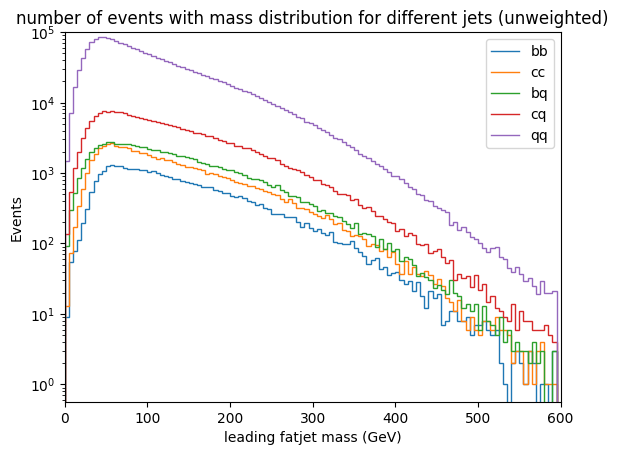

In [20]:
title='with mass distribution for different jets (unweighted)'
xlabel='leading fatjet mass (GeV)'
x_range=(0,600)
y_range=(0, 1e5)
events_num_plot(mass_unweighted, bins, xlabel, title, x_range, y_range, fatjet_name, True)

In [21]:
def fraction_plot(N_bin_flavor, edges, xlabel, title, x_range, y_range, fatjet_name, log):
    N_bin_flavor = np.array(N_bin_flavor)
    N_tot=np.sum(N_bin_flavor, axis=0)
    for i in range(len(N_bin_flavor)):
        plt.stairs(N_bin_flavor[i]/N_tot, edges, label=fatjet_name[i])
    plt.legend()
    if log == True:
        plt.yscale('log')
    plt.ylim(y_range)
    plt.xlim(x_range)
    plt.title('fraction '+title)

/tmp/ipykernel_20436/926228306.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(y_range)


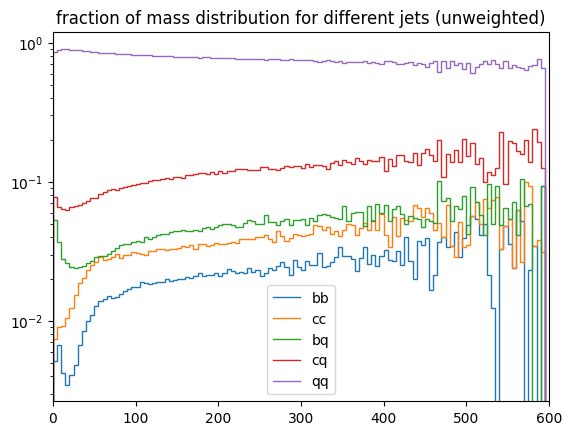

In [22]:
title='of mass distribution for different jets (unweighted)'
xlabel='leading fatjet mass (GeV)'
x_range=(0,600)
y_range=(0, 1.2)
fraction_plot(mass_unweighted, bins, xlabel, title, x_range, y_range, fatjet_name, True)

/tmp/ipykernel_20436/926228306.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(y_range)


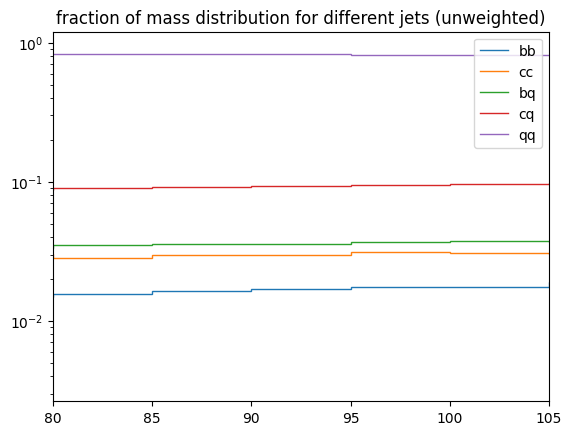

In [90]:
x_range=(80,105)
fraction_plot(mass_unweighted, bins, xlabel, title, x_range, y_range, fatjet_name, True)

#### pT for different jets

In [ ]:
bins = np.linspace(200,1000,100)
pT_unweighted, pT_weighted = generate_histo(events.fatJetPt, bins, 'pT',  fatjet_name, flavor_tagging)

In [ ]:
title='with pT distribution for different jets (unweighted)'
xlabel='leading fatjet pT (GeV)'
x_range=(200,1000)
y_range=(0, 1e5)
events_num_plot(pT_unweighted, bins, xlabel, title, x_range, y_range, fatjet_name, True)

In [ ]:
title='of pT distribution for different jets (unweighted)'
y_range=(0, 1)
fraction_plot(pT_unweighted, bins, xlabel, title, x_range, y_range, fatjet_name, True)

In [ ]:
alpha = [1, .75, .5, .25, .1]
for tag, name, alpha_value in zip(flavor_tagging[:2], fatjet_name[:2], alpha[:2]): 
    plt.hist(events.fatJetPt[tag][:,0].compute(), alpha=alpha_value, bins=50, range=(200, 1000), label=name, density=True)
    print('The range of %s pT is from %.1f to %.1f GeV'%(name, ak.min(events.fatJetPt[tag][:,0].compute()),ak.max(events.fatJetPt[tag][:,0].compute())))
plt.xlabel(r"leading fatjet pT (GeV)")
plt.ylabel("Events")
#plt.yscale('log')
plt.legend()

### Fitting

In [6]:
histo_file_path = '/fs/ddn/sdf/group/ldmx/users/dongyi/Higgs/Histograms.root'
histo = uproot.open(histo_file_path)
keys_name = [key[:-2] for key in histo.keys()]
keys_name[5]

'unweighted_QCD_tot'

$$\sigma_{frac}^2=\frac{N_{bb}}{N_{tot}^3}(N_{tot}+N_{bb})$$

In [7]:
QCD_bb_hist, edges = histo[keys_name[0]].to_numpy()
QCD_cc_hist, edges = histo[keys_name[1]].to_numpy()
QCD_tot_hist, edges = histo[keys_name[5]].to_numpy()
bb_errors = np.sqrt(QCD_bb_hist/QCD_tot_hist**3*(QCD_bb_hist+QCD_tot_hist))
cc_errors = np.sqrt(QCD_cc_hist/QCD_tot_hist**3*(QCD_cc_hist+QCD_tot_hist))
frac_bb = QCD_bb_hist/QCD_tot_hist
frac_cc = QCD_cc_hist/QCD_tot_hist

actual Avg bb fraction = 1.686720 +- 0.051380  %
actual Avg cc fraction = 2.997014 +- 0.068899  %
9590.805393144488 10042.153317168355 451.34826720203273 9795.0 327542.0


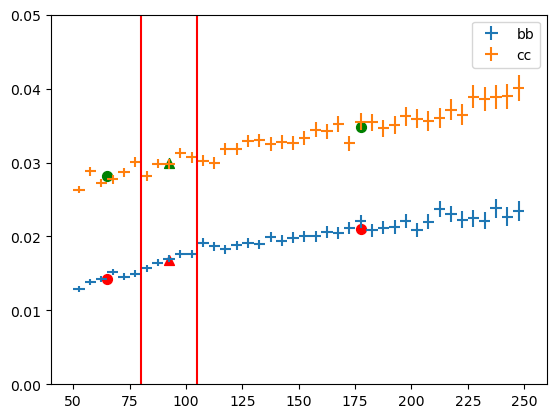

In [14]:
plt.errorbar((edges[:-1]+edges[1:])/2, frac_bb, yerr=bb_errors, xerr=(edges[1]-edges[0])/2, linestyle='', label='bb')
plt.errorbar((edges[:-1]+edges[1:])/2, frac_cc, yerr=cc_errors, xerr=(edges[1]-edges[0])/2, linestyle='', label='cc')
y_range=(0,.05)
plt.plot([80]*5, np.linspace(0,.05,5), 'r')
plt.plot([105]*5, np.linspace(0,.05,5), 'r')

left_avg_x = np.average(edges[:(np.where(edges==80)[0][0]+1)])
right_avg_x = np.average(edges[np.where(edges==105)[0][0]:])
middle_avg_x = np.average(edges[np.where(edges==80)[0][0]:(np.where(edges==105)[0][0]+1)])
left_avg_frac_bb = np.average(frac_bb[:np.where(edges==80)[0][0]])
left_avg_frac_cc = np.average(frac_cc[:np.where(edges==80)[0][0]])
right_avg_frac_bb = np.average(frac_bb[(np.where(edges==105)[0][0]):])
right_avg_frac_cc = np.average(frac_cc[(np.where(edges==105)[0][0]):])
middle_avg_frac_bb = np.average(frac_bb[np.where(edges==80)[0][0]:(np.where(edges==105)[0][0])])
middle_avg_frac_cc = np.average(frac_cc[np.where(edges==80)[0][0]:(np.where(edges==105)[0][0])])
middle_var_frac_bb = np.sqrt(np.average(bb_errors[np.where(edges==80)[0][0]:(np.where(edges==105)[0][0])]**2))
middle_var_frac_cc = np.sqrt(np.average(cc_errors[np.where(edges==80)[0][0]:(np.where(edges==105)[0][0])]**2))
N_cc=sum(QCD_cc_hist[np.where(edges==80)[0][0]:(np.where(edges==105)[0][0])])
N_tot=sum(QCD_tot_hist[np.where(edges==80)[0][0]:(np.where(edges==105)[0][0])])

print('actual Avg bb fraction = %f +- %f '%(middle_avg_frac_bb*100, middle_var_frac_bb*100), '%')
print('actual Avg cc fraction = %f +- %f '%(middle_avg_frac_cc*100, middle_var_frac_cc*100), '%')
print((middle_avg_frac_cc-middle_var_frac_cc)*N_tot, (middle_avg_frac_cc+middle_var_frac_cc)*N_tot, middle_var_frac_cc*N_tot*2, N_cc, N_tot)

plt.scatter(left_avg_x, left_avg_frac_bb, s=50, c='red')
plt.scatter(right_avg_x, right_avg_frac_bb, s=50, c='red')
plt.scatter(middle_avg_x, middle_avg_frac_bb, s=50, c='red', marker='^')

plt.scatter(left_avg_x, left_avg_frac_cc, s=50, c='green')
plt.scatter(right_avg_x, right_avg_frac_cc, s=50, c='green')
plt.scatter(middle_avg_x, middle_avg_frac_cc, s=50, c='green', marker='^')

plt.ylim(y_range)
plt.legend()

## Use FatJetNBHadron to do the tagging

### Selection Rule 2

Aside from tagging fatjet with vrjet information, one can also use fatJetNB(C)Hadron to define bb/cc jets.
- if fatJetNBHadrons=2 & fatJetNCHadron>-1, tag fatjet as bb jet.
- if fatJetNBHadrons=0 & fatJetNCHadron=2, tag fatjet as cc jet.
- if fatJetNBHadrons=0 & fatJetNCHadron=0, tag fatjet as qq jet.

In [644]:
def generate_GN2XHxxScore_single_cut(cut_pt_m, dx):
    bb_tagging = cut_pt_m & (events.fatJetNBHadrons == 2) & (events.fatJetNCHadrons > -1)
    cc_tagging = cut_pt_m & (events.fatJetNBHadrons == 0) & (events.fatJetNCHadrons == 2)
    qq_tagging = cut_pt_m & (events.fatJetNBHadrons == 0) & (events.fatJetNCHadrons == 0)
    
    cuts = [bb_tagging, cc_tagging, qq_tagging]
    tagging_names = ['bb', 'cc', 'qq']
    
    GN2XHbbScore=[]
    GN2XHccScore=[]
    
    #dx = .02 # step for the HxxScore
    N_bins = int(1./dx)
    edges = np.arange(0,1+dx,dx)
    
    for cut, name in zip(cuts, tagging_names):
        GN2XHbbScore.append(np.histogram(ak.flatten(events.fatJetGN2Xv01Hbb[cut]).compute(), bins=N_bins, range=(0,1))[0])
        GN2XHccScore.append(np.histogram(ak.flatten(events.fatJetGN2Xv01Hcc[cut]).compute(), bins=N_bins, range=(0,1))[0])
    return GN2XHbbScore, GN2XHccScore, cuts, tagging_names

In [647]:
# Wihthout any Hbb/cc socre cuts
cut_pt_m = (events.fatJetPt < 450) & (events.fatJetPt > 300) & (events.fatJetM > 105) & (events.fatJetM < 210)
dx = .02
GN2XHbbScore_1D, GN2XHccScore_1D, cuts, tagging_names = generate_GN2XHxxScore_single_cut(cut_pt_m, dx)

fig, axs=plt.subplots(1,2, figsize = (10,4))

for Hbb, Hcc, name in zip(GN2XHbbScore_1D, GN2XHccScore_1D, tagging_names):
    axs[0].stairs(Hbb, edges, label=name)
    axs[1].stairs(Hcc, edges, label=name)
for i in range(len(axs)):
    axs[i].legend()
    axs[i].set_yscale('log')
    axs[i].set_ylabel('Number of events')

axs[0].set_xlabel('GN2XHbbScore')
axs[1].set_xlabel('GN2XHccScore')

KeyboardInterrupt: 

In [8]:
# total number of events for bb, cc, qq jets (without any Hbb/HccScore cuts)
Ntot = np.zeros(len(cuts))
for i in range(len(cuts)):
    Ntot[i] = sum(GN2XHbbScore_1D[i])
    print('number of %s jets'%tagging_names[i], sum(GN2XHbbScore_1D[i]))

number of bb jets 44419.0
number of cc jets 91182.0
number of qq jets 766190.0


In [22]:
def generate_GN2XHxxScore_double_cut(cut_pt_m, dx, bb_score, cc_score, order):
    bb_tagging = cut_pt_m & (events.fatJetNBHadrons == 2) & (events.fatJetNCHadrons > -1)
    cc_tagging = cut_pt_m & (events.fatJetNBHadrons == 0) & (events.fatJetNCHadrons == 2)
    qq_tagging = cut_pt_m & (events.fatJetNBHadrons == 0) & (events.fatJetNCHadrons == 0)
    
    cuts = [bb_tagging, cc_tagging, qq_tagging]
    tagging_names = ['bb', 'cc', 'qq']
    
    GN2XHbbScore=[]
    GN2XHccScore=[]
    
    #dx = .02 # step for the HxxScore
    N_bins = int(1./dx)
    edges = np.arange(0,1+dx,dx)

    
    for cut, name in zip(cuts, tagging_names):
        if order == 'bb':
            GN2XHbbScore.append(np.histogram(ak.flatten(events.fatJetGN2Xv01Hbb[cut&(events.fatJetGN2XHbb<bb_score)]).compute(), bins=N_bins, range=(0,1))[0])            
            GN2XHccScore.append(np.histogram(ak.flatten(events.fatJetGN2Xv01Hcc[cut&(events.fatJetGN2XHbb<bb_score)]).compute(), bins=N_bins, range=(0,1))[0])
        elif order == 'cc':
            GN2XHbbScore.append(np.histogram(ak.flatten(events.fatJetGN2Xv01Hbb[cut&(events.fatJetGN2XHcc>cc_score)]).compute(), bins=N_bins, range=(0,1))[0])
            GN2XHccScore.append(np.histogram(ak.flatten(events.fatJetGN2Xv01Hcc[cut&(events.fatJetGN2XHcc>cc_score)]).compute(), bins=N_bins, range=(0,1))[0])
        else:
            print('wrong input')

    
    return GN2XHbbScore, GN2XHccScore

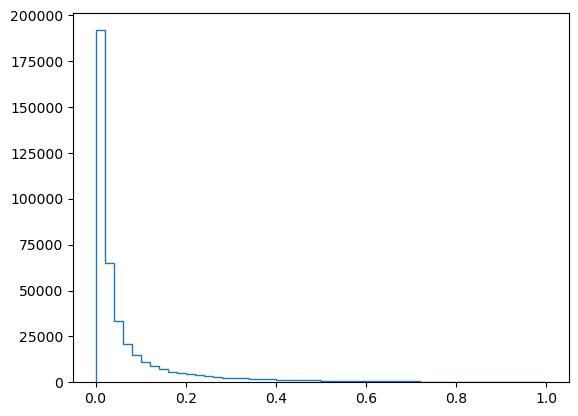

In [41]:
edges = np.arange(0,1+dx,dx)
plt.stairs(GN2XHccScore_2D[2], edges)

### GN2XHbb/Hcc Score for different jets

In [646]:
# Wihthout any Hbb/cc socre cuts
GN2XHbbScore_1D, GN2XHccScore_1D, cuts, tagging_names = generate_GN2XHxxScore_single_cut(cut_pt_m, dx)
fig, axs=plt.subplots(1,2, figsize = (10,4))

for Hbb, Hcc, name in zip(GN2XHbbScore_1D, GN2XHccScore_1D, tagging_names):
    axs[0].stairs(Hbb, edges, label=name)
    axs[1].stairs(Hcc, edges, label=name)
for i in range(len(axs)):
    axs[i].legend()
    axs[i].set_yscale('log')
    axs[i].set_ylabel('Number of events')

axs[0].set_xlabel('GN2XHbbScore')
axs[1].set_xlabel('GN2XHccScore')

KeyboardInterrupt: 

***Conclusion:***
- bb tagging is more efficient than cc tagging since Hbb tagger reduces qq jets more efficiently compare to Hcc tagger.
- In Hcc tagger, cc jets even has a slightly decrease when HccScore approaches to 1, which is opposite to the increase that Hbb taggers has for bb jets.
- Hcc tagger has a huge improvement space.

#### Hbb/Hcc taggers with different pT slicing (支线任务)
We assume that Hcc tagger will behave differently in different pT ranges. Since selection above is in high pT range, we will investigate how HccScore perform at lower pT(200-450 GeV) in the following

In [106]:
cut_pt_m = (events.fatJetPt < 450) & (events.fatJetPt > 300) & (events.fatJetM > 105) & (events.fatJetM < 210)
dx = .02
GN2XHbbScore_low_pT, GN2XHccScore_low_pT = generate_GN2XHxxScore(cut_pt_m, dx)

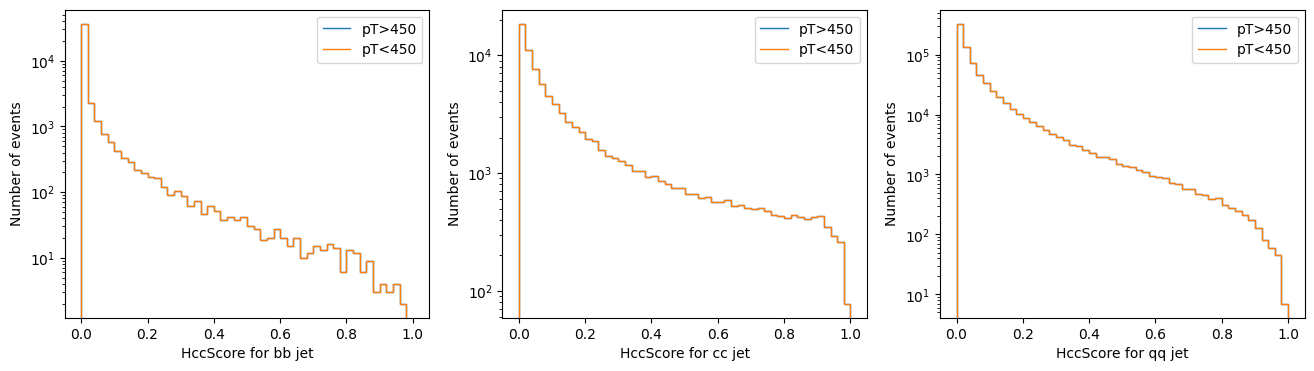

In [107]:
fig, axs=plt.subplots(1,3, figsize = (16,4))
i=0
for high_pT, low_pT, name in zip(GN2XHccScore, GN2XHccScore_low_pT, tagging_names):
    axs[i].stairs(high_pT, edges, label='pT>450')
    axs[i].stairs(low_pT, edges, label='300<pT<450')
    axs[i].set_xlabel('HccScore for '+name+' jet')
    i+=1
for i in range(len(axs)):
    axs[i].legend()
    axs[i].set_yscale('log')
    axs[i].set_ylabel('Number of events')


***Summary:***
Hcc taggers behaves the same at both pT regions.

### bb, cc, qq Efficiency with different HbbScore cuts
Now we only focus on the high pT region. We define bb efficiency as the ratio of the number of bb jets with certain HbbScore range $N_{bb}^{HbbScore<n}$ to total number of bb $N_{bb}$. Apparently, $N_{bb}^{0<HbbScore<1}=N_{bb}$. 
$$\epsilon_{bb}=\frac{N_{bb}^{HbbScore<n}}{N_{bb}}$$

[]

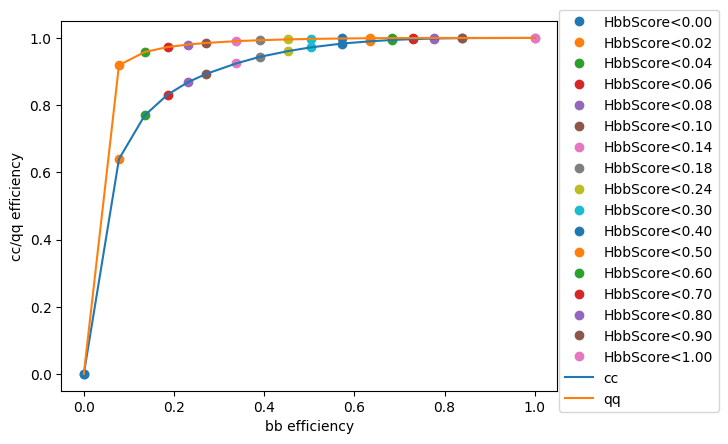

In [136]:
scores = [0, 1, 2, 3, 4, 5, 7, 9, 12, 15, 20, 25, 30, 35, 40, 45, 50]
Nbb_eff_less = []
Ncc_eff_less = []
Nqq_eff_less = []
count = 0
for score in scores:
    Nbb = sum(GN2XHbbScore[0][:score])/Ntot[0]
    Ncc = sum(GN2XHbbScore[1][:score])/Ntot[1]
    Nqq = sum(GN2XHbbScore[2][:score])/Ntot[2]
    Nbb_eff_less.append(Nbb)
    Ncc_eff_less.append(Ncc)
    Nqq_eff_less.append(Nqq)
    plt.plot(Nbb, Ncc, 'o', color='C%i'%count, label='HbbScore<%.2f'%(score*dx))
    plt.plot(Nbb, Nqq, 'o', color='C%i'%count)
    count += 1
plt.plot(Nbb_eff_less, Ncc_eff_less, '-', label='cc')
plt.plot(Nbb_eff_less, Nqq_eff_less, '-', label='qq')
plt.legend(bbox_to_anchor=(.99, 1.05))
plt.xlabel('bb efficiency')
plt.ylabel('cc/qq efficiency')
plt.plot()

In [19]:
%%time
bb_scores = [0, 1, 2, 3, 4, 5, 7, 9, 12, 15, 20, 25, 30, 35, 40, 45, 50]
#cc_scores = [0, 1, 2, 3, 4, 5, ]
Nbb_eff_less = []
Ncc_eff_less = []
Nqq_eff_less = []
count = 0
for bb_score in bb_scores[1:2]:
    Nbb_tot = sum(GN2XHbbScore_1D[0][:bb_score]) # Ntot is the sum of events with HbbScore cuts
    Ncc_tot = sum(GN2XHbbScore_1D[1][:bb_score])
    Nqq_tot = sum(GN2XHbbScore_1D[2][:bb_score])
    print('Nbb_tot',Nbb_tot)
    for cc_score in bb_scores[:3]:
        GN2XHbbScore_2D, GN2XHccScore_2D = generate_GN2XHxxScore_double_cut(cut_pt_m, dx, bb_score, cc_score, 'bb')
        print(sum(GN2XHbbScore_2D[0]))
        Nbb = sum(GN2XHccScore_2D[0][cc_score:])/Nbb_tot   
        Ncc = sum(GN2XHccScore_2D[1][cc_score:])/Ncc_tot
        Nqq = sum(GN2XHccScore_2D[2][cc_score:])/Nqq_tot

    Nbb_eff_less.append(Nbb)
    Ncc_eff_less.append(Ncc)
    Nqq_eff_less.append(Nqq)
    plt.plot(Ncc, Nbb, 'o', color='C%i'%count, label='HbbScore<%.2f'%(score*dx))
    plt.plot(Ncc, Nqq, 'o', color='C%i'%count)
    count += 1
plt.plot(Ncc_eff_less, Nbb_eff_less, '-', label='bb')
plt.plot(Ncc_eff_less, Nqq_eff_less, '--', label='qq')
plt.legend(bbox_to_anchor=(.99, 1.05))
plt.xlabel('cc efficiency')
plt.ylabel('bb/qq efficiency')
plt.plot()

Nbb_tot 3464.0
44419.0


KeyboardInterrupt: 

### Accelerate programming with dask & Generating data (Hbb/Hcc Scores with different cuts)
Make histograms of GN2XHbbScore and GN2XHccScore with two single cuts (HbbScore>a, HccScore>b), and one double cut (HbbScore>a & HccScore>b) separtely. In each histogram, there are a bb/cc/qq tagging folder inside it, which means each histogram has the form ([Array1],[Array2],[Array3]), indecating (bb, cc, qq)

In [650]:
from dask.distributed import Client

client = Client("tls://172.16.134.78:8786")
client

Connection method: Direct,
Dashboard: /user/dongyi.liu@cern.ch/proxy/8787/status,
Comm: tls://172.16.134.78:8786,Workers: 0
Dashboard: /user/dongyi.liu@cern.ch/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


#### Cut Choice 1: HbbScore>a & HccScore>b

In [590]:
import coffea.processor as processor

class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, events, N_bins, bb_score, cc_score):
        cut_pt_m = (events.fatJetPt > 450) & ((events.fatJetM > 105) & (events.fatJetM < 210)) | ((events.fatJetM > 50) & (events.fatJetM < 80)) 
        di_fatjet = ak.num(events.fatJetPt) == 2
        
        bb_tagging = cut_pt_m & (events.fatJetNBHadrons == 2) & (events.fatJetNCHadrons > -1)
        cc_tagging = cut_pt_m & (events.fatJetNBHadrons == 0) & (events.fatJetNCHadrons == 2)
        qq_tagging = cut_pt_m & (events.fatJetNBHadrons == 0) & (events.fatJetNCHadrons == 0)
        
        cuts = {'bb': bb_tagging, 'cc': cc_tagging, 'qq': qq_tagging}

        h_GN2XHbbScore_Hbbcut = (had.Hist.new.StrCat(list(cuts), name='cut')
            .Regular(N_bins, 0, 1, name='Hbbscore').Double())
        h_GN2XHccScore_Hbbcut = (had.Hist.new.StrCat(list(cuts), name='cut')
            .Regular(N_bins, 0, 1, name='Hccscore').Double())
        h_GN2XHbbScore_Hcccut = (had.Hist.new.StrCat(list(cuts), name='cut')
            .Regular(N_bins, 0, 1, name='Hbbscore').Double())
        h_GN2XHccScore_Hcccut = (had.Hist.new.StrCat(list(cuts), name='cut')
            .Regular(N_bins, 0, 1, name='Hccscore').Double())
        h_GN2XHbbScore_bothcut = (had.Hist.new.StrCat(list(cuts), name='cut')
            .Regular(N_bins, 0, 1, name='Hbbscore').Double())
        h_GN2XHccScore_bothcut = (had.Hist.new.StrCat(list(cuts), name='cut')
            .Regular(N_bins, 0, 1, name='Hccscore').Double())
        h_pT_bothcut = (had.Hist.new.StrCat(list(cuts), name='cut')
            .Regular(N_bins, 200, 1000, name='pT').Double())
        h_mass_bothcut = (had.Hist.new.StrCat(list(cuts), name='cut')
            .Regular(N_bins, 0, 200, name='mass').Double())
        
        HbbScorecuts = events.fatJetGN2Xv01Hbb > bb_score
        HccScorecuts = events.fatJetGN2Xv01Hcc > cc_score

        for name, cut in cuts.items():
            h_GN2XHbbScore_Hbbcut.fill(cut=name, Hbbscore=ak.flatten(events.fatJetGN2Xv01Hbb[di_fatjet & cut & HbbScorecuts]))
            h_GN2XHbbScore_Hcccut.fill(cut=name, Hbbscore=ak.flatten(events.fatJetGN2Xv01Hbb[di_fatjet & cut & HccScorecuts]))
            h_GN2XHbbScore_bothcut.fill(cut=name, Hbbscore=ak.flatten(events.fatJetGN2Xv01Hbb[di_fatjet & cut & HccScorecuts & HbbScorecuts]))
            h_GN2XHccScore_Hbbcut.fill(cut=name, Hccscore=ak.flatten(events.fatJetGN2Xv01Hcc[di_fatjet & cut & HbbScorecuts]))
            h_GN2XHccScore_Hcccut.fill(cut=name, Hccscore=ak.flatten(events.fatJetGN2Xv01Hcc[di_fatjet & cut & HccScorecuts]))
            h_GN2XHccScore_bothcut.fill(cut=name, Hccscore=ak.flatten(events.fatJetGN2Xv01Hcc[di_fatjet & cut & HccScorecuts & HbbScorecuts]))
            h_pT_bothcut.fill(cut=name, pT=ak.flatten(events.fatJetPt[di_fatjet & cut & HccScorecuts & HbbScorecuts]))
            h_mass_bothcut.fill(cut=name, mass=ak.flatten(events.fatJetM[di_fatjet & cut & HccScorecuts & HbbScorecuts]))


        return {
            "entries": ak.num(events, axis=0),
            "GN2XHbbScore_Hbbcut": h_GN2XHbbScore_Hbbcut,
            "GN2XHccScore_Hbbcut": h_GN2XHccScore_Hbbcut,
            "GN2XHbbScore_Hcccut": h_GN2XHbbScore_Hcccut,
            "GN2XHccScore_Hcccut": h_GN2XHccScore_Hcccut,
            "GN2XHbbScore_bothcut": h_GN2XHbbScore_bothcut,
            "GN2XHccScore_bothcut": h_GN2XHccScore_bothcut,
            "pT": h_pT_bothcut,
            "mass": h_mass_bothcut,
            "cuts": 'HbbScorecuts>%.2f, HccScorecuts>%.2f'%(bb_score, cc_score),
        }

    def postprocess(self, accumulator):
        pass

[How to save dictionary in python](https://stackoverflow.com/questions/7100125/storing-python-dictionaries), [pickle documentation](https://docs.python.org/3/library/pickle.html#data-stream-format)

In [121]:
%%time
bb_scores = np.array([0, 1, 2, 3, 4, 5, 7, 9, 12, 15, 20, 25, 30, 35, 40, 45, 50])*.02
cc_scores = np.array([0., .01, .02, .03, .04, .06, .08, .1, .2, .3, .5, .7, .9])

try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

for bb_score in tqdm_notebook(bb_scores[:], total=len(bb_scores), desc="Processing records"):
    for cc_score in cc_scores[:]:
        p = MyProcessor()
        out = p.process(events, 50, bb_score, cc_score)
        (computed,) = dask.compute(out)
        #print(computed['cuts'])
        with open('%s.p'%(computed['cuts']), 'wb') as fp:
            pickle.dump(computed, fp, protocol=pickle.HIGHEST_PROTOCOL)


<timed exec>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Processing records:   0%|          | 0/17 [00:00<?, ?it/s]

HbbScorecuts>0.00, HccScorecuts>0.00
HbbScorecuts>0.00, HccScorecuts>0.01
HbbScorecuts>0.00, HccScorecuts>0.02
HbbScorecuts>0.00, HccScorecuts>0.03
HbbScorecuts>0.00, HccScorecuts>0.04
HbbScorecuts>0.00, HccScorecuts>0.06
HbbScorecuts>0.00, HccScorecuts>0.08
HbbScorecuts>0.00, HccScorecuts>0.10
HbbScorecuts>0.00, HccScorecuts>0.20
HbbScorecuts>0.00, HccScorecuts>0.30
HbbScorecuts>0.00, HccScorecuts>0.50
HbbScorecuts>0.00, HccScorecuts>0.70
HbbScorecuts>0.00, HccScorecuts>0.90
HbbScorecuts>0.02, HccScorecuts>0.00
HbbScorecuts>0.02, HccScorecuts>0.01
HbbScorecuts>0.02, HccScorecuts>0.02
HbbScorecuts>0.02, HccScorecuts>0.03
HbbScorecuts>0.02, HccScorecuts>0.04
HbbScorecuts>0.02, HccScorecuts>0.06
HbbScorecuts>0.02, HccScorecuts>0.08
HbbScorecuts>0.02, HccScorecuts>0.10
HbbScorecuts>0.02, HccScorecuts>0.20
HbbScorecuts>0.02, HccScorecuts>0.30
HbbScorecuts>0.02, HccScorecuts>0.50
HbbScorecuts>0.02, HccScorecuts>0.70
HbbScorecuts>0.02, HccScorecuts>0.90
HbbScorecuts>0.04, HccScorecuts>0.00
H

#### Cut Choice 2: HbbScore<a & HccScore>b

In [651]:
import coffea.processor as processor

class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, events, N_bins, bb_score, cc_score):
        cut_pt_m = (events.fatJetPt > 450) & ((events.fatJetM > 105) & (events.fatJetM < 210)) | ((events.fatJetM > 50) & (events.fatJetM < 80)) 
        di_fatjet = ak.num(events.fatJetPt) == 2
        
        bb_tagging = cut_pt_m & (events.fatJetNBHadrons == 2) & (events.fatJetNCHadrons > -1)
        cc_tagging = cut_pt_m & (events.fatJetNBHadrons == 0) & (events.fatJetNCHadrons == 2)
        qq_tagging = cut_pt_m & (events.fatJetNBHadrons == 0) & (events.fatJetNCHadrons == 0)
        
        cuts = {'bb': bb_tagging, 'cc': cc_tagging, 'qq': qq_tagging}

        h_GN2XHbbScore_Hbbcut = (had.Hist.new.StrCat(list(cuts), name='cut')
            .Regular(N_bins, 0, 1, name='Hbbscore').Double())
        h_GN2XHccScore_Hbbcut = (had.Hist.new.StrCat(list(cuts), name='cut')
            .Regular(N_bins, 0, 1, name='Hccscore').Double())
        h_GN2XHbbScore_Hcccut = (had.Hist.new.StrCat(list(cuts), name='cut')
            .Regular(N_bins, 0, 1, name='Hbbscore').Double())
        h_GN2XHccScore_Hcccut = (had.Hist.new.StrCat(list(cuts), name='cut')
            .Regular(N_bins, 0, 1, name='Hccscore').Double())
        h_GN2XHbbScore_bothcut = (had.Hist.new.StrCat(list(cuts), name='cut')
            .Regular(N_bins, 0, 1, name='Hbbscore').Double())
        h_GN2XHccScore_bothcut = (had.Hist.new.StrCat(list(cuts), name='cut')
            .Regular(N_bins, 0, 1, name='Hccscore').Double())
        h_pT_bothcut = (had.Hist.new.StrCat(list(cuts), name='cut')
            .Regular(N_bins, 200, 1000, name='pT').Double())
        h_mass_bothcut = (had.Hist.new.StrCat(list(cuts), name='cut')
            .Regular(N_bins, 50, 200, name='mass').Double())
        
        HbbScorecuts = events.fatJetGN2Xv01Hbb < bb_score
        HccScorecuts = events.fatJetGN2Xv01Hcc > cc_score

        for name, cut in cuts.items():
            h_GN2XHbbScore_Hbbcut.fill(cut=name, Hbbscore=ak.flatten(events.fatJetGN2Xv01Hbb[di_fatjet & cut & HbbScorecuts]))
            h_GN2XHbbScore_Hcccut.fill(cut=name, Hbbscore=ak.flatten(events.fatJetGN2Xv01Hbb[di_fatjet & cut & HccScorecuts]))
            h_GN2XHbbScore_bothcut.fill(cut=name, Hbbscore=ak.flatten(events.fatJetGN2Xv01Hbb[di_fatjet & cut & HccScorecuts & HbbScorecuts]))
            h_GN2XHccScore_Hbbcut.fill(cut=name, Hccscore=ak.flatten(events.fatJetGN2Xv01Hcc[di_fatjet & cut & HbbScorecuts]))
            h_GN2XHccScore_Hcccut.fill(cut=name, Hccscore=ak.flatten(events.fatJetGN2Xv01Hcc[di_fatjet & cut & HccScorecuts]))
            h_GN2XHccScore_bothcut.fill(cut=name, Hccscore=ak.flatten(events.fatJetGN2Xv01Hcc[di_fatjet & cut & HccScorecuts & HbbScorecuts]))
            h_pT_bothcut.fill(cut=name, pT=ak.flatten(events.fatJetPt[di_fatjet & cut & HccScorecuts & HbbScorecuts]))
            h_mass_bothcut.fill(cut=name, mass=ak.flatten(events.fatJetM[di_fatjet & cut & HccScorecuts & HbbScorecuts]))


        return {
            "entries": ak.num(events, axis=0),
            "GN2XHbbScore_Hbbcut": h_GN2XHbbScore_Hbbcut,
            "GN2XHccScore_Hbbcut": h_GN2XHccScore_Hbbcut,
            "GN2XHbbScore_Hcccut": h_GN2XHbbScore_Hcccut,
            "GN2XHccScore_Hcccut": h_GN2XHccScore_Hcccut,
            "GN2XHbbScore_bothcut": h_GN2XHbbScore_bothcut,
            "GN2XHccScore_bothcut": h_GN2XHccScore_bothcut,
            "pT": h_pT_bothcut,
            "mass": h_mass_bothcut,
            "cuts": 'HbbScorecuts<%.2f, HccScorecuts>%.2f'%(bb_score, cc_score),
        }

    def postprocess(self, accumulator):
        pass

#### Irregular bb scores and cc scores choice VS regular bb and cc scores choice
- bb_scores = np.array([0. , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.14, 0.18, 0.24, 0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 1. ])
- cc_scores = np.array([0., .01, .02, .03, .04, .06, .08, .1, .2, .3, .5, .7, .9])

#### reggular bb and cc scores choice
- bb_scores = cc_scores = np.array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [620]:
def bb_cc_scores_generator(score_choice):
    if score_choice == 1:
        bb_scores = np.array([0, 1, 2, 3, 4, 5, 7, 9, 12, 15, 20, 25, 30, 35, 40, 45, 50])*.02
        cc_scores = np.array([0., .01, .02, .03, .04, .06, .08, .1, .2, .3, .5, .7, .9])
    if score_choice == 2:
        bb_scores = np.linspace(0,1,11)
        cc_scores = np.linspace(0,1,11)
    return bb_scores, cc_scores

In [624]:
def file_path_generator(cut_choice, score_choice, bb_score, cc_score):
    if cut_choice == 1:
        if score_choice == 1:
            file_path = '../../GN2cuts/dijet_bkg/Hbbgreater_Hccgreater/irregular_scores/HbbScorecuts>%.2f, HccScorecuts>%.2f.p'%(bb_score, cc_score)
        elif score_choice == 2:
            file_path = '../../GN2cuts/dijet_bkg/Hbbgreater_Hccgreater/regular_scores/HbbScorecuts>%.2f, HccScorecuts>%.2f.p'%(bb_score, cc_score)
        else:
            print('wrong score_choice')
    elif cut_choice == 2:
        if score_choice == 1:
            file_path = '../../GN2cuts/dijet_bkg/Hbbsmaller_Hccgreater/irregular_scores/HbbScorecuts<%.2f, HccScorecuts>%.2f.p'%(bb_score, cc_score)
        elif score_choice == 2:
            file_path = '../../GN2cuts/dijet_bkg/Hbbsmaller_Hccgreater/regular_scores/HbbScorecuts<%.2f, HccScorecuts>%.2f.p'%(bb_score, cc_score)
        else:
            print('wrong score_choice')
    else:
        print('wrong cut_choice')
    return file_path

In [613]:
%%time
cut_choice = 2
score_choice = 2
bb_scores, cc_scores = bb_cc_scores_generator(score_choice)

try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

for bb_score in tqdm_notebook(bb_scores[10:], total=len(bb_scores), desc="Processing records"):
    for cc_score in cc_scores[:]:
        p = MyProcessor()
        out = p.process(events, 50, bb_score, cc_score)
        (computed,) = dask.compute(out)
        file_path = file_path_generator(cut_choice, score_choice, bb_score, cc_score)
        #print(computed['cuts'])
        with open(file_path, 'wb') as fp:
            pickle.dump(computed, fp, protocol=pickle.HIGHEST_PROTOCOL)


<timed exec>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Processing records:   0%|          | 0/17 [00:00<?, ?it/s]

CPU times: user 38.8 s, sys: 528 ms, total: 39.4 s
Wall time: 30min 30s


#### Single scores testing

In [692]:
%%time
p = MyProcessor()
out = p.process(events, 50, bb_score=.9, cc_score=0.8)
(computed,) = dask.compute(out)
print(computed['cuts'])

HbbScorecuts<0.90, HccScorecuts>0.80
CPU times: user 723 ms, sys: 13 ms, total: 736 ms
Wall time: 29.6 s


In [693]:
Hbbcccut = computed

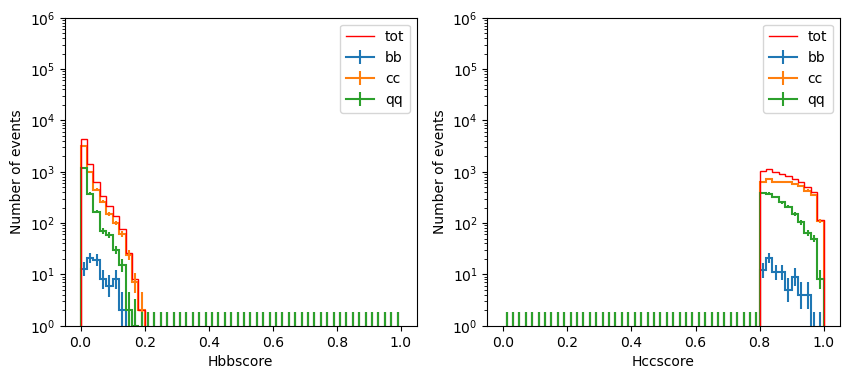

In [710]:
mass_pT_plots(Hbbcccut)

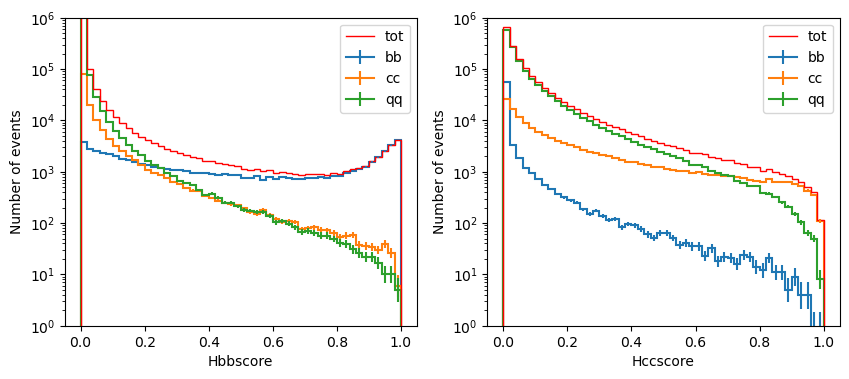

In [714]:
bb_histo, edges, cc_histo, edges = mass_pT_plots(precut)

In [715]:
bb_histo

array([[3.780000e+03, 2.761000e+03, 2.589000e+03, 2.353000e+03,
        2.189000e+03, 1.981000e+03, 1.795000e+03, 1.666000e+03,
        1.522000e+03, 1.391000e+03, 1.357000e+03, 1.242000e+03,
        1.164000e+03, 1.127000e+03, 1.084000e+03, 1.059000e+03,
        1.015000e+03, 9.510000e+02, 9.530000e+02, 9.330000e+02,
        9.130000e+02, 8.700000e+02, 9.030000e+02, 8.590000e+02,
        8.500000e+02, 7.440000e+02, 7.500000e+02, 8.100000e+02,
        6.990000e+02, 7.920000e+02, 7.240000e+02, 7.760000e+02,
        7.480000e+02, 7.160000e+02, 7.320000e+02, 7.590000e+02,
        7.470000e+02, 7.720000e+02, 7.530000e+02, 8.380000e+02,
        8.170000e+02, 9.580000e+02, 1.037000e+03, 1.119000e+03,
        1.242000e+03, 1.578000e+03, 1.900000e+03, 2.517000e+03,
        3.284000e+03, 4.141000e+03],
       [8.023700e+04, 2.008200e+04, 1.025600e+04, 6.483000e+03,
        4.390000e+03, 3.214000e+03, 2.545000e+03, 2.012000e+03,
        1.655000e+03, 1.358000e+03, 1.104000e+03, 9.530000e+02,
   

In [713]:
def mass_pT_plots(computed):
    name1 = 'GN2XHbbScore_bothcut'
    name2 = 'GN2XHccScore_bothcut'
    fix, axs = plt.subplots(1, 2, figsize=(10,4))
    
    computed[name1].plot1d(ax=axs[0])
    computed[name2].plot1d(ax=axs[1])
    histo1 = computed[name1].to_numpy()[0]
    edges1 = computed[name1].to_numpy()[2]
    histo2 = computed[name2].to_numpy()[0]
    edges2 = computed[name2].to_numpy()[2]
    #print(pT)
    axs[0].stairs(np.sum(computed[name1].to_numpy()[0], axis=0), edges1, label='tot', color = 'red')
    axs[1].stairs(np.sum(computed[name2].to_numpy()[0], axis=0), edges2, label='tot', color = 'red')

    for i in range(len(axs)):
        axs[i].legend()
        axs[i].set_yscale('log')
        axs[i].set_ylabel('Number of events')
        axs[i].set_ylim(1, 1e6)
    return histo1, edges1, histo2, edges2

In [697]:
'mass', np.sum(precut['mass'].to_numpy()[0], axis=-1)/np.sum(precut['mass'].to_numpy()[0]),\
'pT', np.sum(precut['pT'].to_numpy()[0], axis=-1)/np.sum(precut['pT'].to_numpy()[0])

('mass',
 array([0.04067711, 0.08626783, 0.87305506]),
 'pT',
 array([0.04113212, 0.08695346, 0.87191442]))

In [698]:
precut['mass'].to_numpy()[0]

array([[  3447.,   3378.,   3258.,   3241.,   3144.,   3050.,   2890.,
          2786.,   2866.,   2734.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,    971.,   1353.,   1290.,
          1336.,   1305.,   1219.,   1312.,   1200.,   1186.,   1192.,
          1193.,   1120.,   1082.,   1111.,   1062.,   1116.,   1066.,
          1047.,    982.,   1033.,    980.,    954.,   1003.,    929.,
           926.,    920.,    843.,    855.,    851.,    805.,    858.,
           794.],
       [  7799.,   7437.,   7319.,   6907.,   6750.,   6540.,   6325.,
          6108.,   5873.,   5695.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,   1982.,   2916.,   2804.,
          2770.,   2780.,   2792.,   2704.,   2561.,   2540.,   2489.,
          2470.,   2359.,   2299.,   2247.,   2315.,   2225.,   2148.,
          2164.,   2063.,   2059.,   2014.,   2020.,   1874.,   1937.,
          1923.,   1798.,   1838.,   1674.,   1730.,   1674

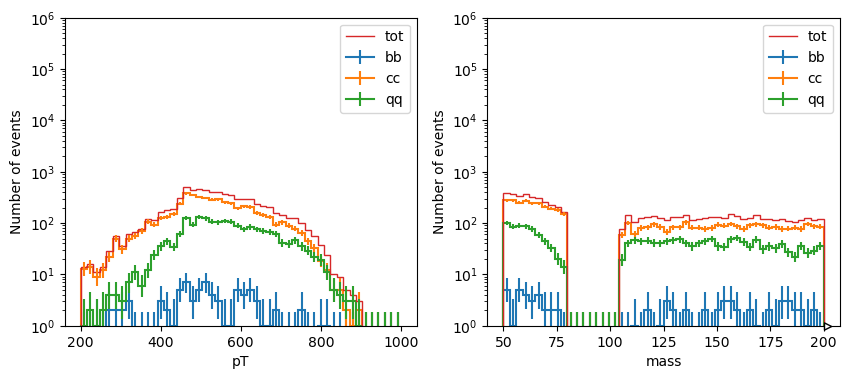

In [688]:
fix, axs = plt.subplots(1, 2, figsize=(10,4))
computed['pT'].plot1d(ax=axs[0])
computed['mass'].plot1d(ax=axs[1])
#pT = computed['pT'].to_numpy()[0]
#print(pT)
axs[0].stairs(np.sum(computed['pT'].to_numpy()[0], axis=0), computed['pT'].to_numpy()[2], label='tot')
axs[1].stairs(np.sum(computed['mass'].to_numpy()[0], axis=0), computed['mass'].to_numpy()[2], label='tot')

for i in range(len(axs)):
    axs[i].legend()
    axs[i].set_yscale('log')
    axs[i].set_ylabel('Number of events')
    axs[i].set_ylim(1, 1e6)

In [ ]:
fix, axs = plt.subplots(2, 2, figsize=(10,10))
computed['GN2XHbbScore_Hbbcut'].plot1d(ax=axs[0][0])
computed['GN2XHbbScore_Hcccut'].plot1d(ax=axs[0][1])
computed['GN2XHccScore_Hbbcut'].plot1d(ax=axs[1][0])
computed['GN2XHccScore_Hcccut'].plot1d(ax=axs[1][1])
for i in range(2):
    for j in range(2):
        axs[i][j].set_yscale('log')
        if j == 0:
            axs[i][j].legend(title="Hbbscore<%.2f"%(bb_score))
        else:
            axs[i][j].legend(title="Hccscore>%.2f"%(cc_score))
plt.show()

#### Draft processors

In [110]:
import coffea.processor as processor

class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, events, bb_scores, cc_scores, N_bins):
        cut_pt_m = (events.fatJetPt > 450) & (events.fatJetM > 105) & (events.fatJetM < 210)
        #N_bins = 50

        bb_tagging = cut_pt_m & (events.fatJetNBHadrons == 2) & (events.fatJetNCHadrons > -1)
        cc_tagging = cut_pt_m & (events.fatJetNBHadrons == 0) & (events.fatJetNCHadrons == 2)
        qq_tagging = cut_pt_m & (events.fatJetNBHadrons == 0) & (events.fatJetNCHadrons == 0)
        
        cuts = {'bb': bb_tagging, 'cc': cc_tagging, 'qq': qq_tagging}
        
        
        N = len(bb_scores) * len(cc_scores)
        
        GN2XHbbHccScore = [(
            had.Hist.new.StrCat(list(cuts), name='cut')
            .Regular(N_bins, 0, 1, name='Hbbscore')
            .Regular(N_bins, 0, 1, name='Hccscore').Double()
        ) for i in range(N)]
        
        count = 0
        for bb_score in bb_scores:
            for cc_score in cc_scores:
                HbbScorecuts = events.fatJetGN2Xv01Hbb < bb_score
                HccScorecuts = events.fatJetGN2Xv01Hcc > cc_score
                for name, cut in cuts.items():
                    GN2XHbbHccScore[count].fill(cut=name, Hbbscore=ak.flatten(events.fatJetGN2Xv01Hbb[cut & HbbScorecuts]),\
                                         Hccscore=ak.flatten(events.fatJetGN2Xv01Hcc[cut & HccScorecuts]))
                count += 1
        
        return {
            "entries": ak.num(events, axis=0),
            "GN2XHbbHccScore": GN2XHbbHccScore,
            "cuts": cuts,
        }

    def postprocess(self, accumulator):
        pass

In [ ]:
import coffea.processor as processor

class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, events, bb_scores, cc_scores, N_bins):
        cut_pt_m = (events.fatJetPt > 450) & (events.fatJetM > 105) & (events.fatJetM < 210)
        #N_bins = 50

        bb_tagging = cut_pt_m & (events.fatJetNBHadrons == 2) & (events.fatJetNCHadrons > -1)
        cc_tagging = cut_pt_m & (events.fatJetNBHadrons == 0) & (events.fatJetNCHadrons == 2)
        qq_tagging = cut_pt_m & (events.fatJetNBHadrons == 0) & (events.fatJetNCHadrons == 0)
        
        cuts = {'bb': bb_tagging, 'cc': cc_tagging, 'qq': qq_tagging}
        
        N = len(bb_scores) * len(cc_scores)

        h_GN2XHbbScore = had.Hist.new.Regular(N_bins,0, 1).Double()
        h_GN2XHccScore = had.Hist.new.Regular(N_bins,0, 1).Double()

        for cut, name in zip(cuts, tagging_names):
            h_GN2XHbbScore.fill(ak.flatten(events.fatJetGN2Xv01Hbb[cut]))
            h_GN2XHccScore.fill(ak.flatten(events.fatJetGN2Xv01Hcc[cut]))

            return {
                "entries": ak.num(events, axis=0),
                "GN2XHbbScore": h_GN2XHbbScore,
                "GN2XHccScore": h_GN2XHccScore,
                "cuts": cuts,
            }

    def postprocess(self, accumulator):
        pass

## Analysis on GN2X tagger

### Test data

In [615]:
def initialize_N(cut_choice, score_choice):
    global Ntot
    global Ncc
    global Nbb
    global Nqq
    if cut_choice == 1:
        bb_score = 0. # HbbScore>0. is equivalent to not adding any cut
        cc_score = 0. # HccScore>0. is equivalent to not adding any cut
    elif cut_choice == 2:
        bb_score = 1. # HbbScore<1 is not adding any cut
        cc_score = 0. # HccScore>0. is equivalent to not adding any cut
    file_path = file_path_generator(cut_choice, score_choice, bb_score=1., cc_score=0.)
    with open(file_path, 'rb') as fp:
        data = pickle.load(fp)
    N_bb_cc_qq = np.sum(data['GN2XHbbScore_Hbbcut'].to_numpy()[0], axis=-1) # Number of bb, cc, qq jets without any cut
    Ntot = np.sum(N_bb_cc_qq)
    Nbb = N_bb_cc_qq[0]
    Ncc = N_bb_cc_qq[1]
    Nqq = N_bb_cc_qq[2]
    return Ntot, Ncc, Nbb, Nqq

In [616]:
cut_choice = 2
score_choice = 2
bb_score=1.
cc_score=.0
file_path = file_path_generator(cut_choice, score_choice, bb_score, cc_score)
with open(file_path, 'rb') as fp:
    data = pickle.load(fp)

In [617]:
# Compute the Ntot for each jet after applying different cuts
Diff_cut_N = [] # [[Nbb,Ncc,Nqq(with Hbb>A cut)], [Nbb,Ncc,Nqq(with Hcc>B cut)], [Nbb,Ncc,Nqq(with Hbb>A & Hcc>B cut)]]
count = 0
for hist_name, hist in data.items():
    if hist_name =='entries' or hist_name =='cuts':
        continue
    print(hist_name, np.sum(data[hist_name].to_numpy()[0], axis=-1))
    if count%2 == 0:
        Diff_cut_N.append(np.sum(data[hist_name].to_numpy()[0], axis=-1))
    count += 1
Diff_cut_N
'''
######## Conclusion #########
- With the same cut, # of different jets should be the same for both GN2XHbb and GN2XHcc
'''

## setup the variables before applying any Hbb/Hcc cut (Note pt_m cut has been applied)
Ntot, Ncc, Nbb, Nqq = initialize_N(cut_choice, score_choice)

GN2XHbbScore_Hbbcut [ 44419.  91182. 766190.]
GN2XHccScore_Hbbcut [ 44419.  91182. 766190.]
GN2XHbbScore_Hcccut [ 44419.  91182. 766190.]
GN2XHccScore_Hcccut [ 44419.  91182. 766190.]
GN2XHbbScore_bothcut [ 44419.  91182. 766190.]
GN2XHccScore_bothcut [ 44419.  91182. 766190.]


In [673]:
def calculate_efficiency_purity(data):
    Ntot_Hbbcut = np.sum(data['GN2XHbbScore_Hbbcut'].to_numpy()[0])
    Ntot_bothcut = np.sum(data['GN2XHbbScore_bothcut'].to_numpy()[0])
    Nbb_Hbbcut, Ncc_Hbbcut, Nqq_Hbbcut= np.sum(data['GN2XHbbScore_Hbbcut'].to_numpy()[0], axis=-1)
    Nbb_bothcut, Ncc_bothcut, Nqq_bothcut= np.sum(data['GN2XHbbScore_bothcut'].to_numpy()[0], axis=-1)
    
    if Ntot_Hbbcut == 0:
        cuts = data['cuts'] + ' Ntot_Hbbcut=0'
        basket = np.zeros(9)
    elif Ntot_bothcut == 0:
        cuts = data['cuts'] + ' Ntot_bothcut=0'
        basket = np.array([Ncc_Hbbcut/Ntot_Hbbcut, 0, Ncc_Hbbcut/Ncc, 0, Nbb_Hbbcut/Nbb, 0, Nqq_Hbbcut/Nqq, 0, 0])
    else:
        cc_purity_Hbbcut = Ncc_Hbbcut/Ntot_Hbbcut # cc fraction with the Hbb cut
        cc_purity_bothcut = Ncc_bothcut/Ntot_bothcut # cc fraction after applying both cuts

        cc_efficiency_Hbbcut = Ncc_Hbbcut/Ncc # number of cc after vs before applying Hbb cut
        cc_efficiency_Hcccut = Ncc_bothcut/Ncc_Hbbcut # number of cc after vs before applying Hcc cut (with a fixed Hbb cut)
        bb_efficiency_Hbbcut = Nbb_Hbbcut/Nbb # number of bb after vs before applying Hbb cut
        bb_efficiency_Hcccut = Nbb_bothcut/Nbb_Hbbcut # number of bb after vs before applying Hcc cut (with a fixed Hbb cut)
        qq_efficiency_Hbbcut = Nqq_Hbbcut/Nqq # number of qq after vs before applying Hbb cut
        qq_efficiency_Hcccut = Nqq_bothcut/Nqq_Hbbcut # number of qq after vs before applying Hcc cut (with a fixed Hbb cut)

        cc_purity_uncertainty_bothcut = np.sqrt(Ncc_bothcut)/Ntot_bothcut

        cuts = data['cuts']
        basket = np.array([cc_purity_Hbbcut, cc_purity_bothcut, cc_efficiency_Hbbcut, cc_efficiency_Hcccut, bb_efficiency_Hbbcut, bb_efficiency_Hcccut,\
                           qq_efficiency_Hbbcut, qq_efficiency_Hcccut, cc_purity_uncertainty_bothcut])    
        
    return basket, cuts

In [674]:
# Trying to find the cuts that can give us the minimal uncertainty
cuts = []
baskets = []
cut_choice = 2
score_choice = 2
bb_scores, cc_scores = bb_cc_scores_generator(score_choice)
dim_bb = len(bb_scores[1:])
dim_cc = len(cc_scores[1:])

for bb_score in bb_scores[1:]:
    for cc_score in cc_scores[:-1]:
        file_path = file_path_generator(cut_choice, score_choice, bb_score, cc_score)
        with open(file_path, 'rb') as fp:
            data = pickle.load(fp)
            basket, cut = calculate_efficiency_purity(data)
            baskets.append(basket)
            cuts.append(cut)
cc_purity_Hbbcut     = np.array(baskets)[:,0]
cc_purity_bothcut    = np.array(baskets)[:,1]
cc_efficiency_Hbbcut = np.array(baskets)[:,2]
cc_efficiency_Hcccut = np.array(baskets)[:,3]
bb_efficiency_Hbbcut = np.array(baskets)[:,4]
bb_efficiency_Hcccut = np.array(baskets)[:,5]
qq_efficiency_Hbbcut = np.array(baskets)[:,6]
qq_efficiency_Hcccut = np.array(baskets)[:,7]
cc_purity_uncertainty_bothcut = np.array(baskets)[:,8]
            
output = {            
    "cc_purity_Hbbcut": np.array(baskets)[:,0],
    "cc_purity_bothcut": np.array(baskets)[:,1],
    "cc_efficiency_Hbbcut": np.array(baskets)[:,2],
    "cc_efficiency_Hcccut": np.array(baskets)[:,3],
    "bb_efficiency_Hbbcut": np.array(baskets)[:,4],
    "bb_efficiency_Hcccut": np.array(baskets)[:,5],
    "qq_efficiency_Hbbcut": np.array(baskets)[:,6],
    "qq_efficiency_Hcccut": np.array(baskets)[:,7],
    "cc_purity_uncertainty_bothcut": np.array(baskets)[:,8],
    "cuts": cuts
}

In [686]:
cc_efficiency_Hbbcut[-12]*cc_efficiency_Hcccut[-12]
#cuts[-12]

0.057105569081616986

Text(0.5, 1.0, 'cc')

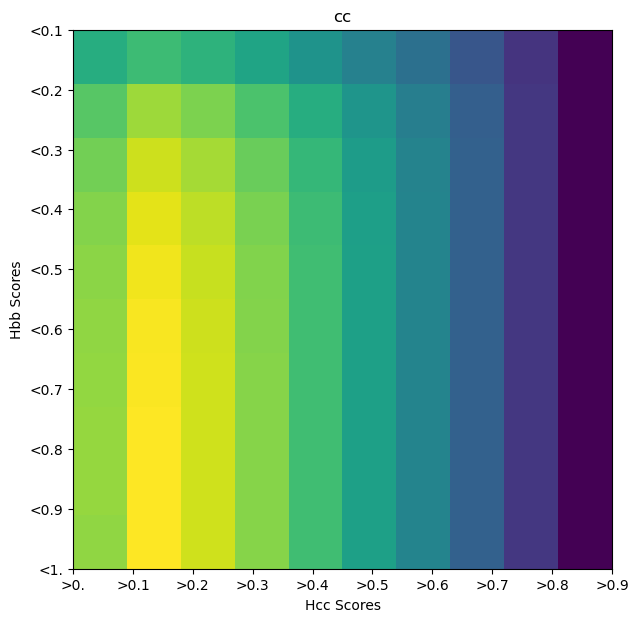

In [631]:
var = cc_purity_bothcut.reshape(dim_bb,dim_cc)*cc_efficiency_Hcccut.reshape(dim_bb,dim_cc)*cc_efficiency_Hbbcut.reshape(dim_bb,dim_cc)
name = 'cc'

HbbScores = np.array([float(output["cuts"][i][13:17]) for i in range(len(output["cuts"]))])
HccScores = np.array([float(output["cuts"][i][32:36]) for i in range(len(output["cuts"]))])

if cut_choice == 1:
    Hbb_score_xticks_label = ['>'+np.array2string(i) for i in HbbScores.reshape(dim_bb,dim_cc)[:, 0]]
elif cut_choice == 2:
    Hbb_score_xticks_label = ['<'+np.array2string(i) for i in HbbScores.reshape(dim_bb,dim_cc)[::-1, 0]]

# Efficiency plots
fig, ax = plt.subplots(1,1, figsize=(7,7))
img = plt.imshow(var, extent=[0,1,0,1])
ax.set_xticks(np.linspace(0, 1, dim_cc), labels=['>'+np.array2string(i) for i in HccScores.reshape(dim_bb,dim_cc)[0]])
ax.set_yticks(np.linspace(0, 1, dim_bb), labels=Hbb_score_xticks_label)
ax.set_xlabel('Hcc Scores')
ax.set_ylabel('Hbb Scores')
ax.set_title(name)

#plt.savefig('../slides_plots/cc_purity_bothcut_2D.png', dpi=200)

In [632]:
cuts[np.where(var==min(var[var!=0]))[0][0]]

'HbbScorecuts<0.10, HccScorecuts>0.20'

In [633]:
cut_choice = 2
score_choice = 2
bb_score=.1
cc_score=.2
file_path = file_path_generator(cut_choice, score_choice, bb_score, cc_score)
with open(file_path, 'rb') as fp:
    data = pickle.load(fp)


"\n######### Conclusion #########\n- Hcc Tagger is correlated to Hbb Tagger. Applying HbbScore > x is equivalent to applying HccScore < (1-x) cut. \n- However, HbbScore < x is not equivalent to applying HccScore > (1-x). HbbScore < x won't affect HccScore range.\n- Hcc Tagger performs not as well as Hbb Tagger since qq and cc behave similarly in Hcc tagger.\n"

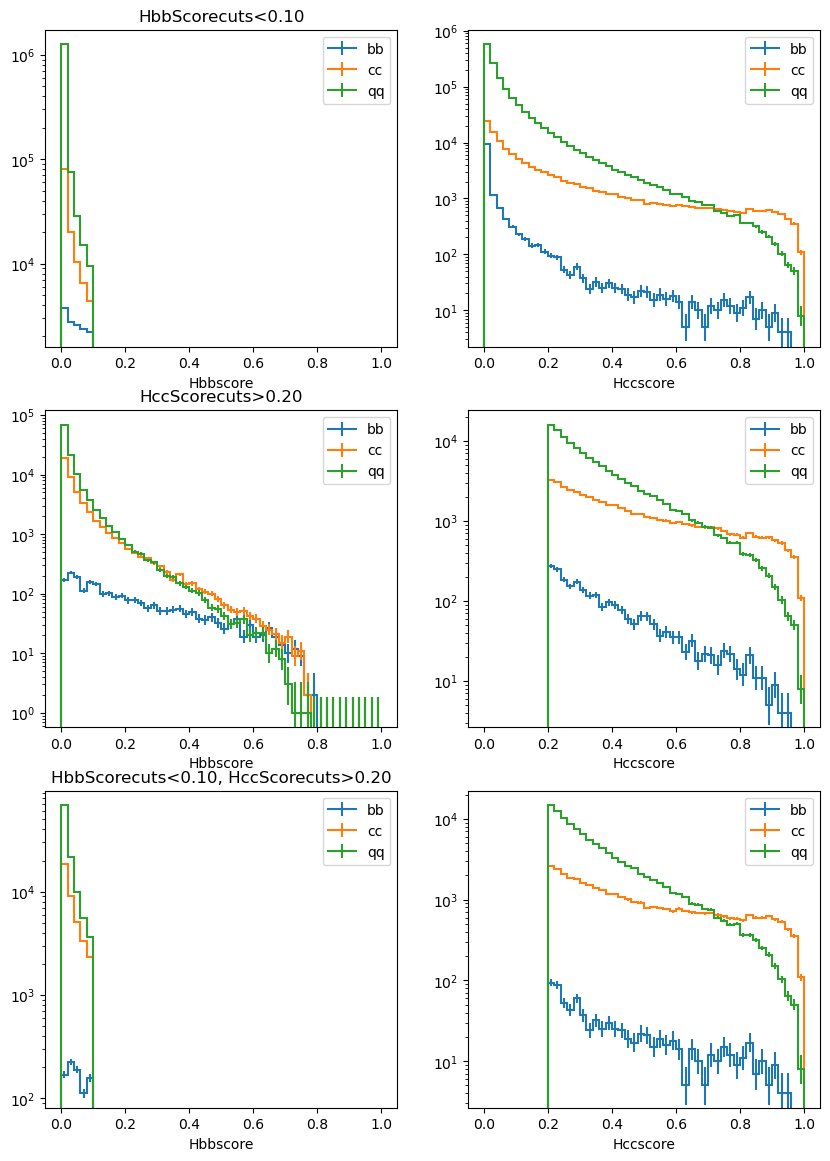

In [636]:
# Make the plot of HbbScore and HccScore in 3 different cases
fig, axs = plt.subplots(3, 2, figsize=(10,14))
count = 0
for hist_name, hist in data.items():
    if hist_name =='entries' or hist_name =='cuts' or hist_name =='pT' or hist_name == 'mass':
        continue
    #print(hist_name)
    data[hist_name].plot1d(ax=axs[int(count/2)][count%2])
    axs[int(count/2)][count%2].set_yscale('log')
    axs[int(count/2)][count%2].legend()
    count += 1
axs[0][0].set_title(data['cuts'][:17])
axs[1][0].set_title(data['cuts'][19:])
axs[2][0].set_title(data['cuts'])

'''
######### Conclusion #########
- Hcc Tagger is correlated to Hbb Tagger. Applying HbbScore > x is equivalent to applying HccScore < (1-x) cut. 
- However, HbbScore < x is not equivalent to applying HccScore > (1-x). HbbScore < x won't affect HccScore range.
- Hcc Tagger performs not as well as Hbb Tagger since qq and cc behave similarly in Hcc tagger.
'''

#### Draft

In [469]:
a = (cc_efficiency_Hcccut*cc_purity_bothcut)
cuts[np.where(a == np.max(a))[0][0]]

'HbbScorecuts<0.80, HccScorecuts>0.03'

Text(0, 0.5, 'Hbb Scores')

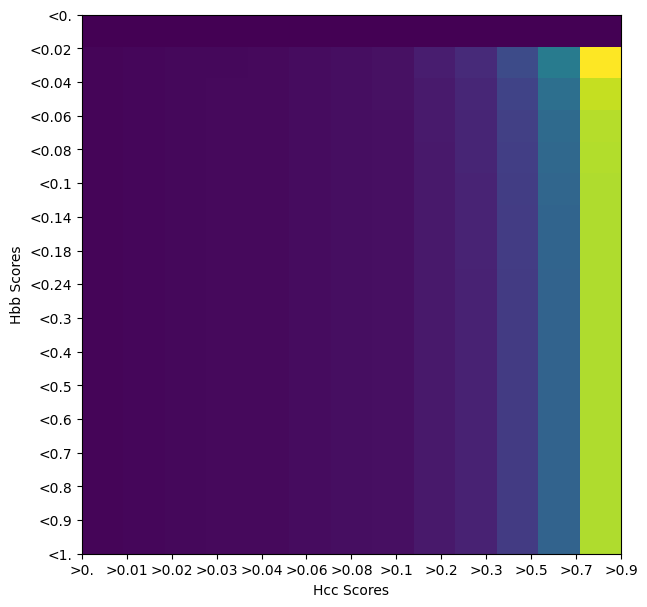

In [449]:
# Efficiency plots
fig, ax = plt.subplots(1,1, figsize=(7,7))
img = plt.imshow(cc_purity_uncertainty_bothcut.reshape(17,13), extent=[0,1,0,1])
ax.set_xticks(np.linspace(0, 1, 13), labels=['>'+np.array2string(i) for i in HccScores.reshape(17,13)[0]])
ax.set_yticks(np.linspace(0, 1, 17), labels=Hbb_score_xticks_label)
ax.set_xlabel('Hcc Scores')
ax.set_ylabel('Hbb Scores')

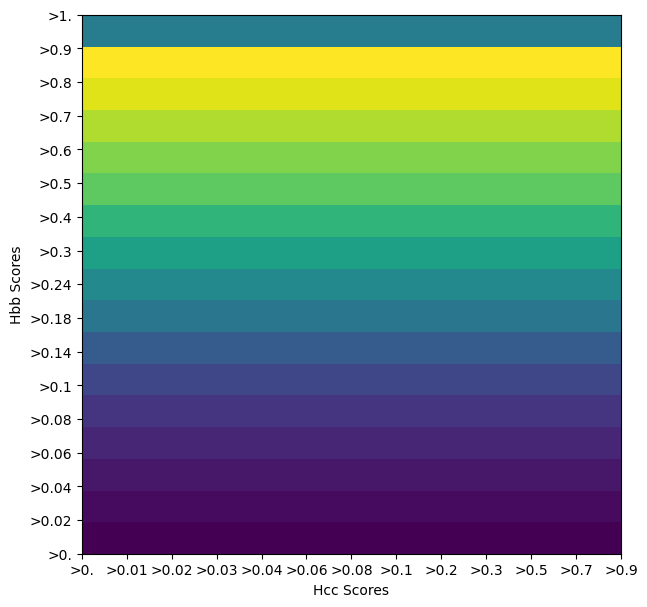

In [372]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
img = plt.imshow(cc_purity_Hbbcut.reshape(17,13), extent=[0,1,0,1])
ax.set_xticks(np.linspace(0, 1, 13), labels=['>'+np.array2string(i) for i in HccScores.reshape(17,13)[0]])
ax.set_yticks(np.linspace(0, 1, 17), labels=['>'+np.array2string(i) for i in HbbScores.reshape(17,13)[:, 0]])
ax.set_xlabel('Hcc Scores')
ax.set_ylabel('Hbb Scores')

plt.savefig('../slides_plots/cc_purity_Hbbcut_2D.png', dpi=200)

In [289]:
np.where(max(cc_purity_Hbbcut))[0]
cuts[0]
cc_efficiency_Hbbcut[0]

/tmp/ipykernel_802/1829522488.py:1: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
  np.where(max(cc_purity_Hbbcut))[0]


1.0

In [235]:
uncertainties=np.array(uncertainties)
min(uncertainties[uncertainties!=0])
np.where(uncertainties==min(uncertainties[uncertainties!=0]))[0]
cuts[np.where(uncertainties==min(uncertainties[uncertainties!=0]))[0][0]]

############ Conclusion ############
#the cuts that can give us the minimal uncertainty is 'HbbScorecuts>0.08, HccScorecuts>0.90'

'HbbScorecuts>0.08, HccScorecuts>0.90'

### Fitting
After choosing the cut of 'HbbScorecuts<0.10, HccScorecuts>0.20', we do the fitting based on the given shapes for each jet

In [586]:
mass = events.fatJetM.compute()

In [568]:
np.sum(data['GN2XHbbScore_bothcut'].to_numpy()[0], axis=-1)

array([  13., 1416.,  320.])

In [637]:
cut_choice = 2
score_choice = 2
bb_score=.1
cc_score=.2
file_path = file_path_generator(cut_choice, score_choice, bb_score, cc_score)
with open(file_path, 'rb') as fp:
    data = pickle.load(fp)

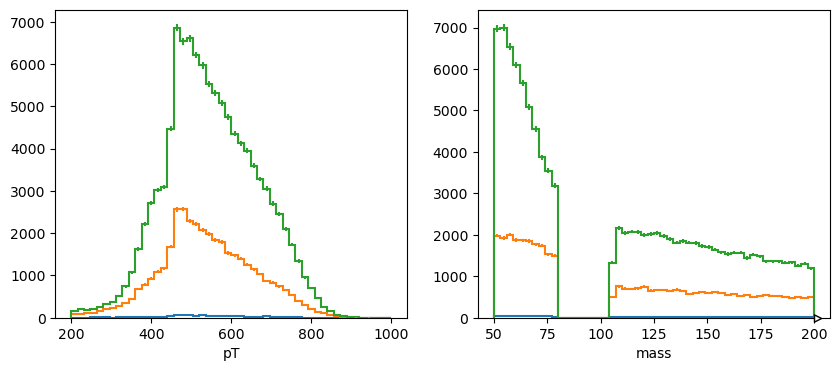

In [643]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
count = 0
for hist_name, hist in data.items():
    if hist_name =='pT' or hist_name =='mass':
        data[hist_name].plot1d(ax=axs[int(count/1)])
        #axs[int(count/1)].set_yscale('log')
        count+=1

# General Questions
1. How to calculate fatjet pT? Is there any relationship between vrjets pT and fatjet pT?
2. Where to get the 4 momentum info? How do convert from (px, py, pz, E) to (phi, eta, pT, m)? Where do those fat jets come from (trigger system?) what's the delta R distribution?
3. How to sort awkward array in a more efficient way? vrjetpT are not sorted. How to build a sorted array?
4. How to use dash to accelerate coffea? Are they equivalent to using CPU cores? If that's the case, should I use dash at all if I can apply enough CPU for jupyter notebook? How many CPU I can apply at most?
5. How to make sure that leading fatjet do come from Higgs? Why do we only care about leading fatjet?

In [ ]:
dr = events[selection_2fatjet][:, 0].delta_r(events[selection_2fatjet][:, 1])

In [ ]:
vrjet_id_0 = vrjet==0
vrjet_id_1 = vrjet==1
# pick vrjet whose id is 0
vrjetpt_id_0 = vrjetpt[vrjet_id_0]
vrjetpt_id_0= vrjetpt_id_0[ak.num(vrjetpt_id_0)>1]
print(len(vrjetpt_id_0))
# check whether it has been sorted or not
vrjetpt_id_0[(vrjetpt_id_0[:,-1] - vrjetpt_id_0[:,-2])>0]
#print(len(vrjetpt_id_0[(vrjetpt_id_0[:,-1] - vrjetpt_id_0[:,-2])>0]))
#vrjetpt_id_1 = vrjetpt[vrjet_id_1]